In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

import sys
# Add path of module (temporary measure until pip install works)
sys.path.append('../sctop')
import sctop as top

In [95]:
# Change seaborn settings to make our plots prettier
# Feel free to edit as desired, or remove entirely
sns.set(context='talk', font_scale=1.0, color_codes=True, palette='deep', style='ticks',
        rc={'mathtext.fontset': 'cm', 'xtick.direction': 'in','ytick.direction': 'in',
            'axes.linewidth': 1.5, 'figure.dpi':150, 'text.usetex':False})

----------------

# Import data
Load the reference database (a processed version of the [Mouse Cell Atlas](http://bis.zju.edu.cn/MCA/index.html)) and load sample data (mouse lung data taken by Michael Herriges, in the [Kotton Lab](https://www.bumc.bu.edu/kottonlab/)).

In [2]:
data_MC20, metadata_MC20 = top.load_basis('MC20-KO22', 0)
rawdata_herriges = pd.read_csv('./21_01_06_herriges_with_week6_invivo.csv')

Now that the reference basis is loaded, we can search for the names of cell types of interest within the database.

The format of cell type label is as follows:

[Organ] [Cell Type] [Time Point] [[Condition (if applicable)]] ([Data Source])

Data source notation:

MC20 - Mouse Cell Atlas

LD21 - Atlas of Lung Development

KO - Kotton lab

ZO - Zorn lab

IK - Ikonomou lab

Time point notation: Up to 21 days post-natal, days are indicated. "E" indicates embryonic day. "P" indicates post-natal day. After 21 days, "WK" is used to indicate post-natal week.

In [94]:
# We can search for specific cell types.
# For example, this is how we can find all labels corresponding to lung cell types
# Note: it is case-sensitive
search_term = 'Lung'

[cell_type for cell_type in metadata_MC20.index if search_term in cell_type]

['Lung Interstitial macrophage WK6-10 (MC20)',
 'Lung Eosinophil granulocyte WK6-10 (MC20)',
 'Lung Stromal cell WK6-10 [Inmt high] (MC20)',
 'Lung T Cell WK6-10 [Cd8b1 high] (MC20)',
 'Lung Basophil WK6-10 (MC20)',
 'Lung Stromal cell E14.5 [Ptn high] (MC20)',
 'Lung Erythroblast E14.5 [Hbb-bs high] (MC20)',
 'Lung Epithelial cell E14.5 [Sftpc high] (MC20)',
 'Lung Erythroblast E14.5 [Mt2&Mt1 high] (MC20)',
 'Lung Dividing T cells WK6-10 (MC20)',
 'Lung Stromal cell WK6-10 [Dcn high] (MC20)',
 'Lung NK Cell WK6-10 (MC20)',
 'Lung Stromal cell WK6-10 [Acta2 high] (MC20)',
 'Lung Conventional dendritic cell WK6-10 [Tubb5 high] (MC20)',
 'Lung Macrophage E14.5 [Lyz2 high] (MC20)',
 'Lung Nuocyte WK6-10 (MC20)',
 'Lung Dendritic cell WK6-10 [Naaa high] (MC20)',
 'Lung Ig−producing B cell WK6-10 (MC20)',
 'Lung Ciliated cell WK6 (KO22)',
 'Lung AT1 Cell WK6 (KO22)',
 'Lung Conventional dendritic cell WK6-10 [H2-M2 high] (MC20)',
 'Lung Neutrophil E14.5 [S100a8 high] (MC20)',
 'Lung Endothe

--------------

Now we load corresponding metadata of the Herriges sample. This allows us to compare our labels with Michael Herriges' labels, and observe how projection score changes according to whether a cell is endogenous or a "transplant" (a stem-cell derived cell that was transplanted into a mouse).

In [3]:
metadata_herriges = pd.read_csv('./herriges_metadata.csv')

# Michael's labels for each of the clusters
cluster_key = {'2':'AT1 and AT1-like',
               '4':'Ciliated',
               '6':'Basal',
               '7':'Gastric-like',
               '8':'Neuroendocrine',
               '0+':'AT2',
               '1+13':'Secretory',
               '3+14':'AT2-like'}

clusters = metadata_herriges['new_clustering.07.12.2021'].values
cluster_labels = [cluster_key[cluster] for cluster in clusters]
identity = metadata_herriges['orig.ident'].values

type_annotations = np.array(cluster_labels)

type_annotations[type_annotations == 'AT2'] = 'AT2 and AT2-like' 
type_annotations[type_annotations == 'AT2-like'] = 'AT2 and AT2-like' 

# Sources for each of the cells
source_annotations = []

for label in identity:
    if 'Transplant' in label:
        source_annotations += ['Transplant']
    elif 'Endogenous' in label:
        source_annotations += ['Endogenous']
    elif 'Control' in label:
        source_annotations += ['Control']
        
source_annotations = np.array(source_annotations)

----------------------------

# Process the raw sample data and calculate projection scores

In [4]:
data_herriges = top.process(rawdata_herriges)
projections_herriges = top.score(data_MC20, data_herriges)

------------------

# Visualize the projection scores

First, define some functions for plotting the data.

In [48]:
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D

# =========================
# Define plotting functions
# =========================

# Create bar plot of the highest projection scores for a particular sample
def plot_highest(projections, n=10, ax=None, **kwargs):
    ax = ax or plt.gca()
    
    projections_sorted = projections.sort_values(by=projections.columns[0])
    projections_top10 = projections_sorted.iloc[-n:]
    return projections_top10.plot.barh(ax=ax, **kwargs)

# Helper function for creating a color bar
def create_colorbar(data, label, colormap='rocket_r', ax = None):
    ax = ax or plt.gca()
    
    scalarmap = ScalarMappable(norm=plt.Normalize(min(data), max(data)),
                               cmap=plt.get_cmap(colormap))
    scalarmap.set_array([])
    plt.colorbar(scalarmap, label=label, ax = ax)
    
    return plt.get_cmap(colormap)

# Create scatter plot showing projections of each cell in a tSNE plot, for a given cell type
def plot_tSNE(projections, tSNE_data, cell_type, ax=None, **kwargs):
    ax = ax or plt.gca()
    
    type_projections = np.array(projections.loc[cell_type]).T
    
    palette = create_colorbar(type_projections, 'Projection onto {}'.format(cell_type),
                             ax = ax)
    
    plot = sns.scatterplot(x = tSNE_data[:,0],
                           y = tSNE_data[:,1],
                           hue = type_projections,
                           palette = palette,
                           alpha = 0.5,
                           ax = ax,
                           **kwargs
                          )
    plot.legend_.remove()
    
# Create scatter plot showing top projection types for each cell
def plot_top(projections, tSNE_data, minimum_cells=200, ax=None, **kwargs):
    ax = ax or plt.gca()
        
    top_types = projections.idxmax().values
    unique_types = np.unique(top_types, return_counts=True)
    other_types = []

    for i, count in enumerate(unique_types[1]):
        if count < minimum_cells:
            other_types += [unique_types[0][i]]

    for i, cell_type in enumerate(top_types):
        if cell_type in other_types:
            top_types[i] = "Other"
            
    sns.scatterplot(x = tSNE_data[:,0],
                           y = tSNE_data[:,1],
                           hue = top_types,
                           alpha = 0.5,
                           ax = ax, 
                           **kwargs
                          )
    
# Create scatter plot showing projection scores for two cell types, with the option to
# color according to marker gene
def plot_two(projections, celltype1, celltype2, 
             gene=None, gene_expressions=None, ax=None, **kwargs):
    
    ax = ax or plt.gca()

    if gene:
        palette = create_colorbar(gene_expressions.loc[gene],
                                  '{} expression'.format(gene), ax = ax)
        
        plot = sns.scatterplot(x = projections.loc[celltype1],
                        y = projections.loc[celltype2],
                        hue = gene_expressions.loc[gene],
                        palette = palette,
                        alpha = 0.5,
                        ax = ax,
                        **kwargs
                       )
        plot.legend_.remove()
        
    else:
        sns.scatterplot(x = projections.loc[celltype1],
                        y = projections.loc[celltype2],
                        alpha=0.5,
                        ax=ax,
                        **kwargs
                       )

In [67]:
# Set some keyword arguments we'll re-use for our scatter plots
kwargs = {'s':40,
          'style':source_annotations
         }

# A custom legend illustrating the source annotations
source_legend = [Line2D([0], [0], marker='o', color='w', label='Endogenous',
                              markerfacecolor='k', markersize=10),
                      Line2D([0], [0], marker='X', color='w', label='Transplant',
                              markerfacecolor='k', markersize=10),
                      Line2D([0], [0], marker='s', color='w', label='Control',
                              markerfacecolor='k', markersize=10)]

There are many ways to visualize the data. One way is to look at the top projection scores for your sample (or sub-sample).

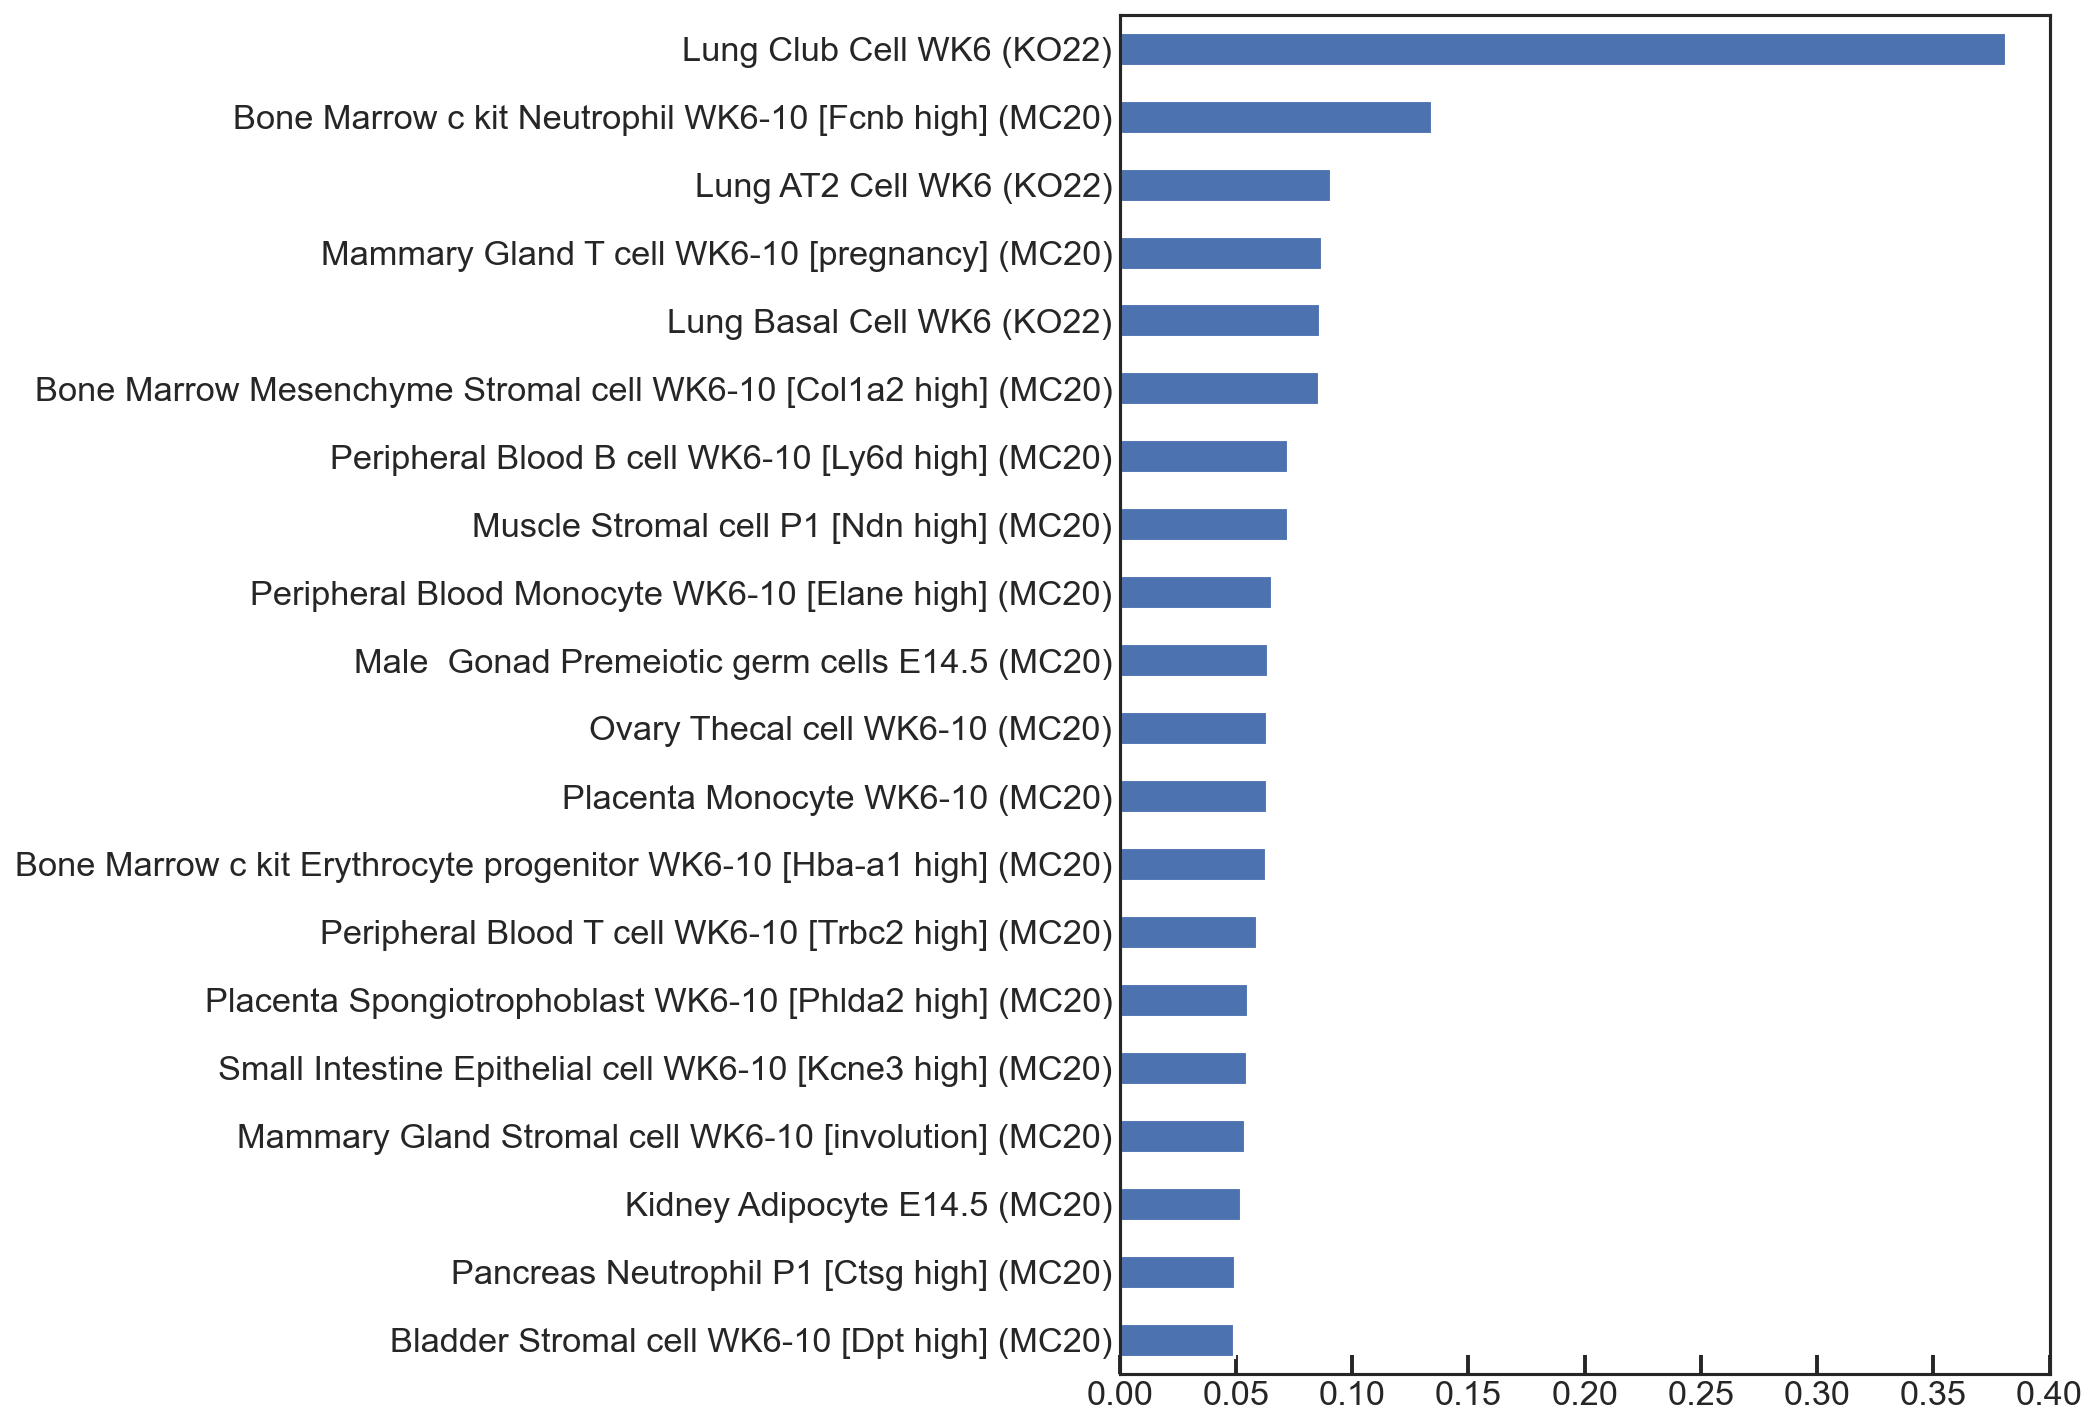

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(8,12))
plot_highest(pd.DataFrame(projections_herriges[0]), legend=None, n=20)
plt.show()

Another way we can visualize the data is to plot the projections onto two cell types of interest.

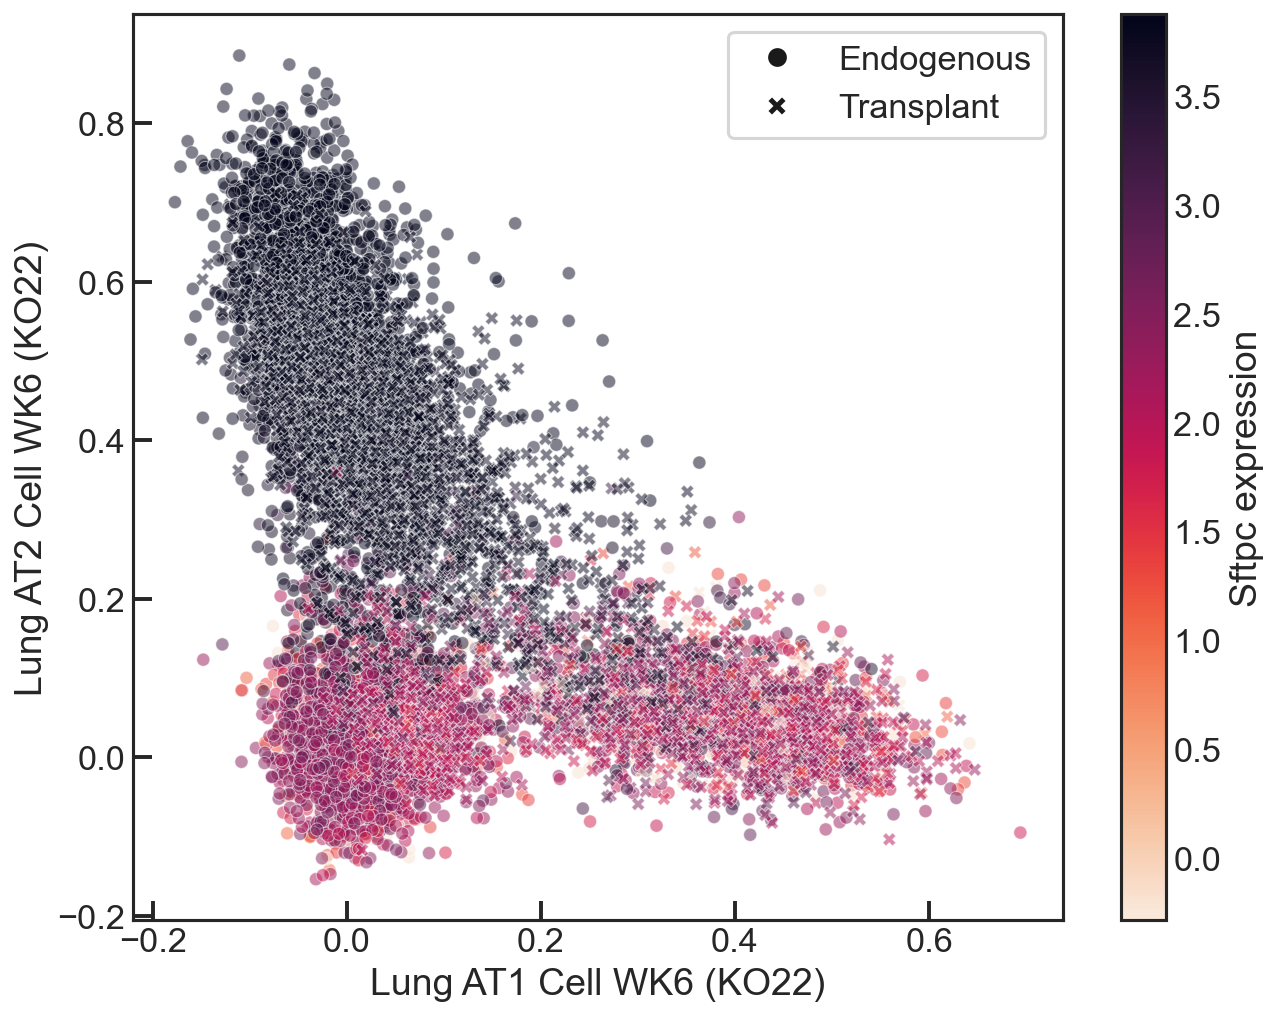

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
plot_two(projections_herriges.loc[:,source_annotations!='Control'], 
         'Lung AT1 Cell WK6 (KO22)', 'Lung AT2 Cell WK6 (KO22)',
         gene = 'Sftpc', gene_expressions = data_herriges, ax=ax, **kwargs)
plt.legend(handles=source_legend[:2])
plt.show()

We can compare our projection scores to annotations created manually by biologists. They match very well!

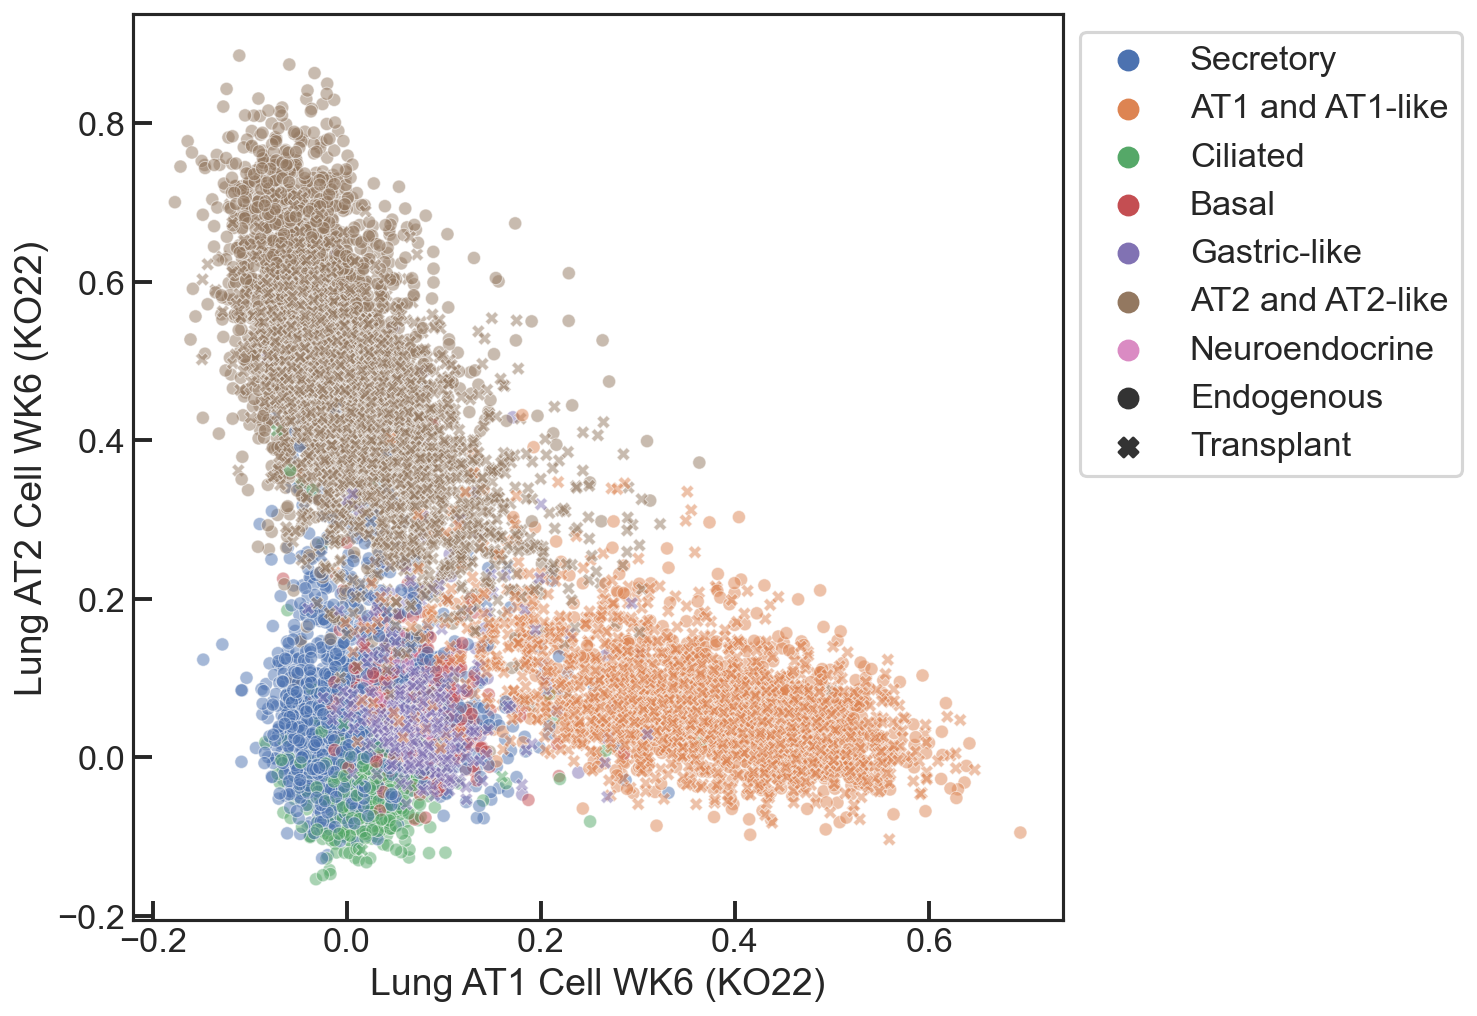

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
plot_two(projections_herriges.loc[:,source_annotations!='Control'],
         'Lung AT1 Cell WK6 (KO22)', 'Lung AT2 Cell WK6 (KO22)',
         ax=ax, hue=type_annotations[source_annotations!='Control'],
         s=40, style=source_annotations[source_annotations!='Control'])
plt.legend(bbox_to_anchor=(1,1))
plt.show()

We can use dimensional reduction (such as t-SNE) to visualize the data, then use our projection scores to color each point.

In [22]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(100)
PCA_data = pca.fit_transform(data_herriges.T)

tsne = TSNE(n_components=2,perplexity=20)
tSNE_data = tsne.fit_transform(PCA_data)

We can color each cell according to the projection onto one particular cell type.

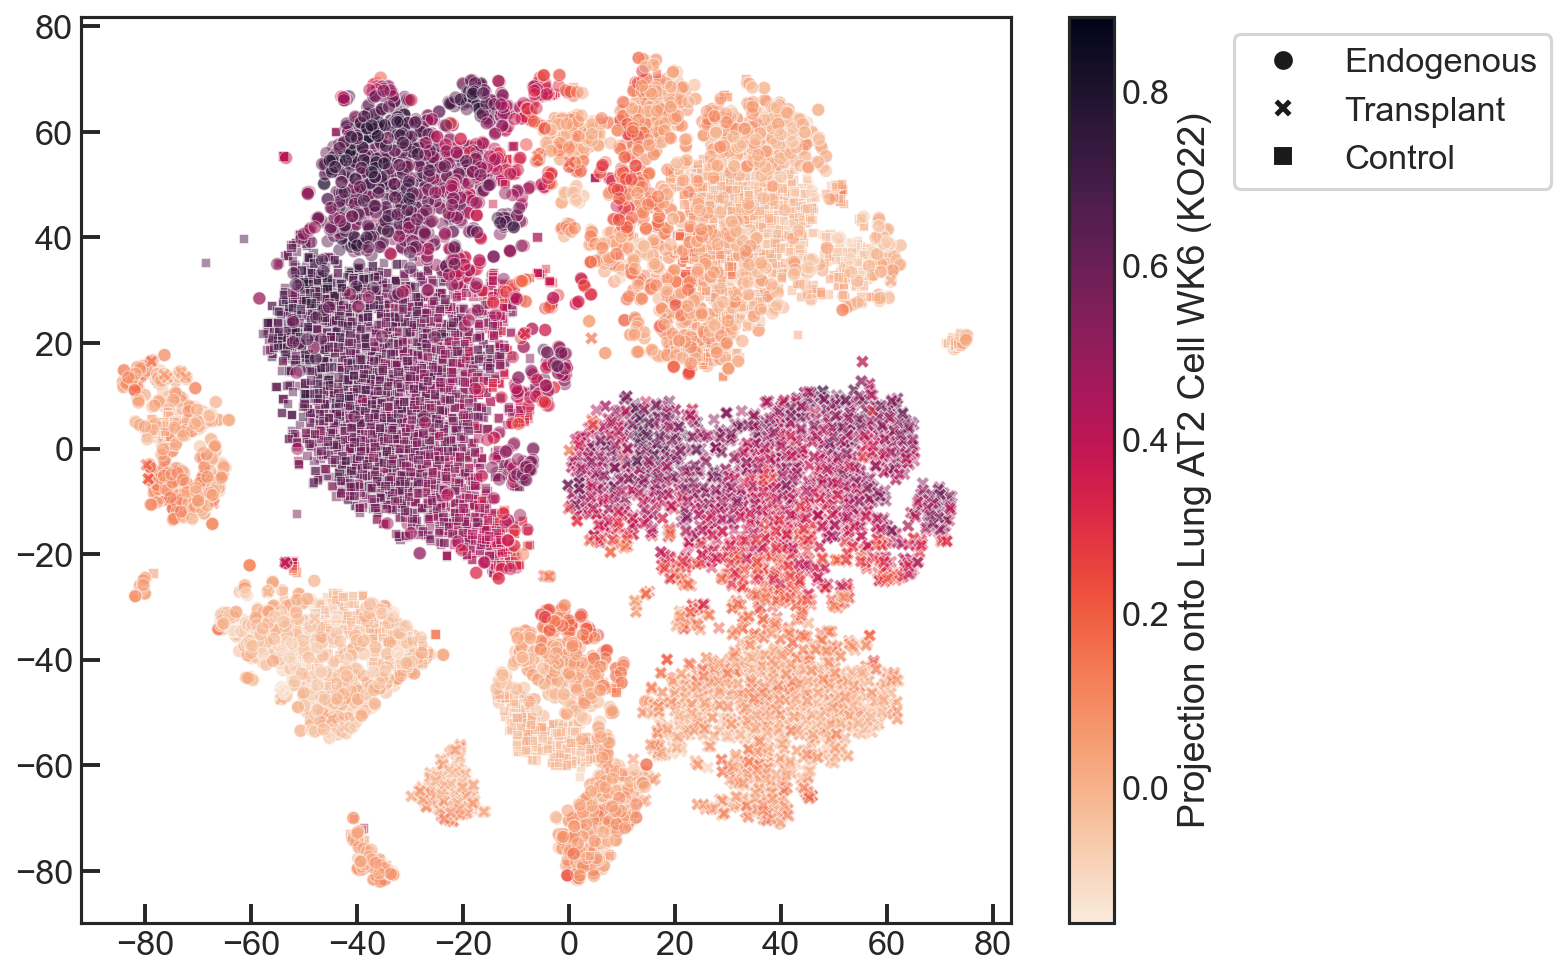

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
plot_tSNE(projections_herriges, tSNE_data, 'Lung AT2 Cell WK6 (KO22)', **kwargs)

ax.legend(handles=source_legend, bbox_to_anchor=(1.6,1))
plt.show()

Alternatively, we can color each cell according to the cell type with the highest projection.

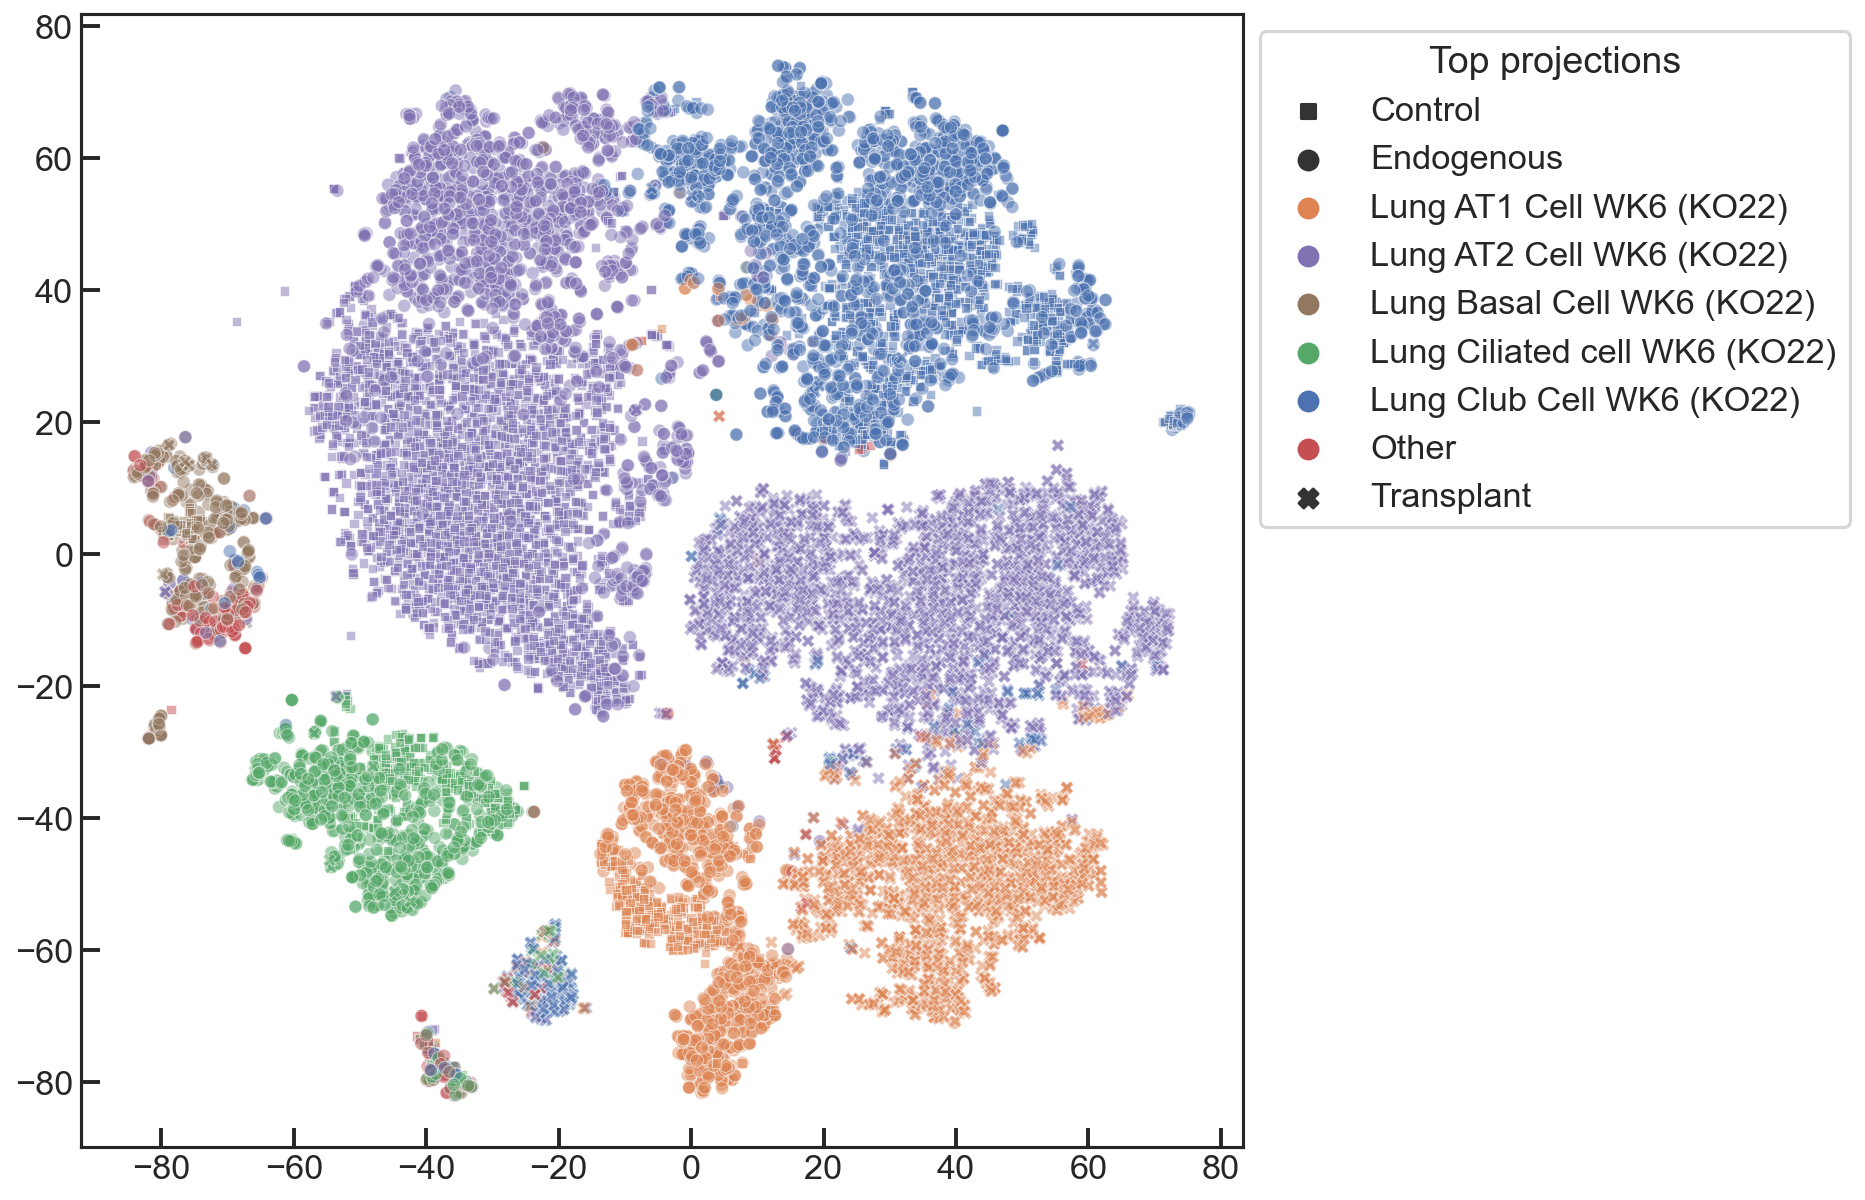

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
plot_top(projections_herriges, tSNE_data, **kwargs)

handles, labels = ax.get_legend_handles_labels()
# sort the legend labels (this snippet of code was taken from Stack Overflow user "kevin")
# source: stackoverflow.com/questions/22263807/how-is-order-of-items-in-matplotlib-legend-determined
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles, labels, bbox_to_anchor=(1,1), title='Top projections')

plt.show()